# Model

## Requirements

- import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

- constant variables

In [2]:
DESKTOP_DIR = "C:/Users/mapmxj/Desktop/"

- functions

In [3]:
from general_functions import data_validation, data_profiling, data_exploration
from ml_classification import *

## EDA

### Load Data

In [4]:
filename = "..\\data\\train.csv"
raw_df = pd.read_csv(filename)

raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


### Data Profile

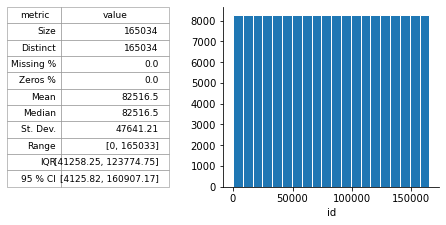

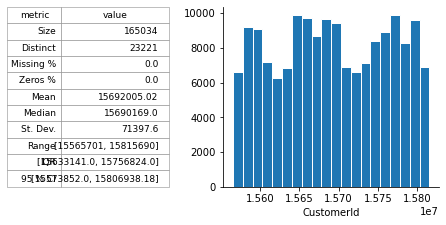

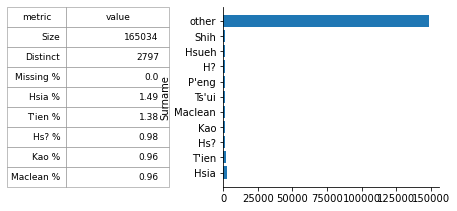

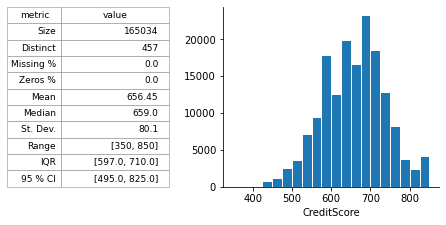

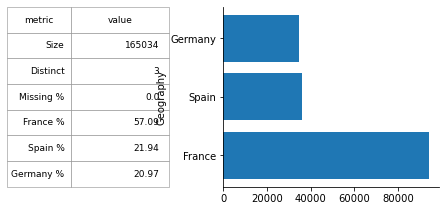

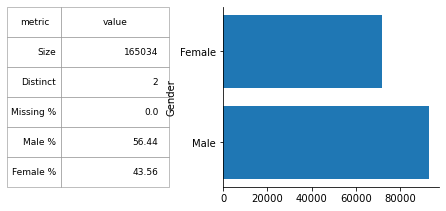

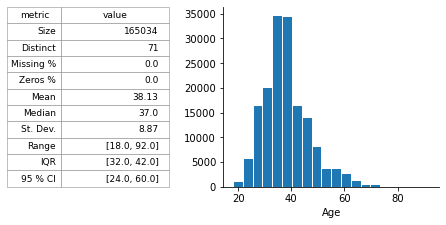

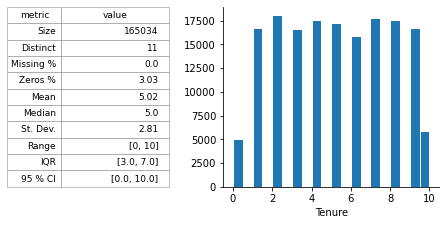

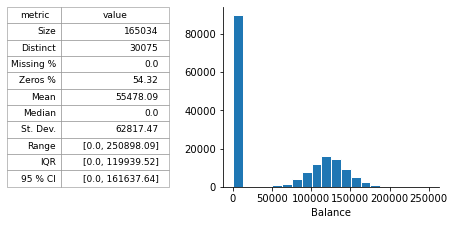

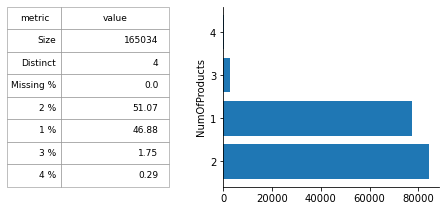

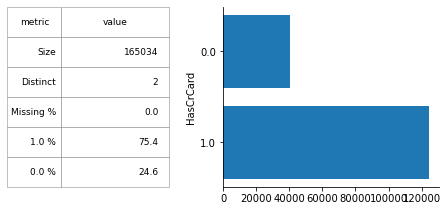

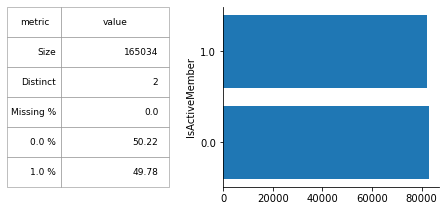

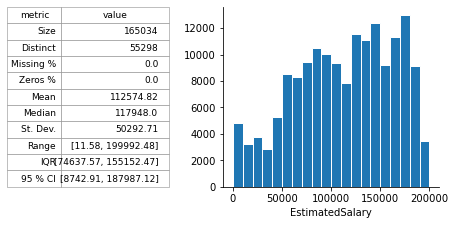

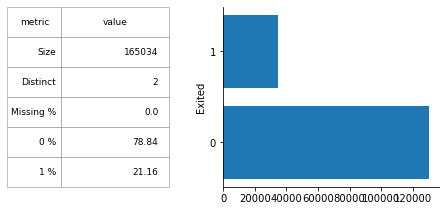

In [5]:
data_profiling.summarize_data(raw_df)

### XY correlations

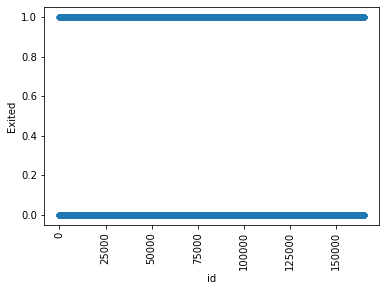

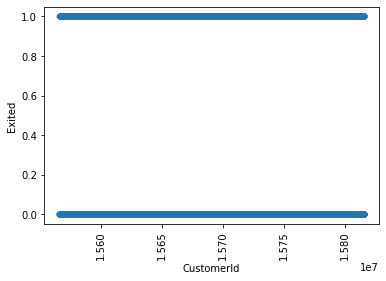

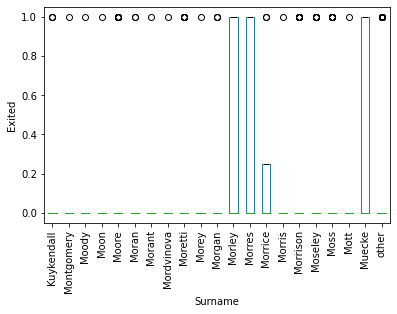

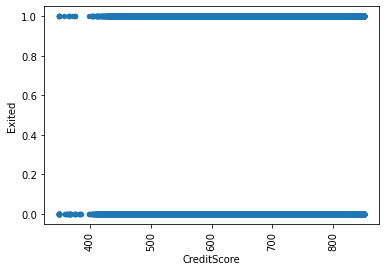

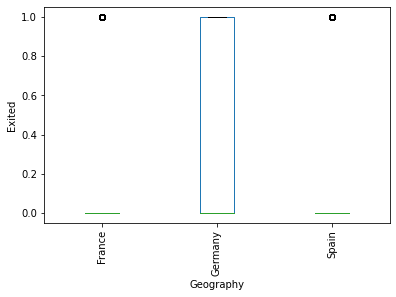

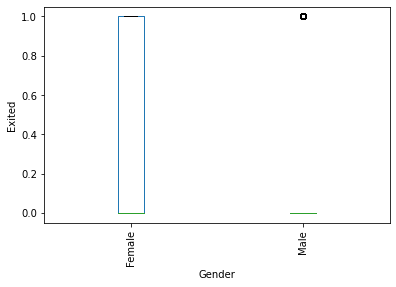

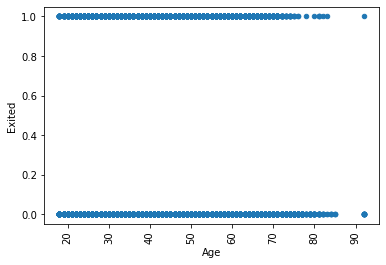

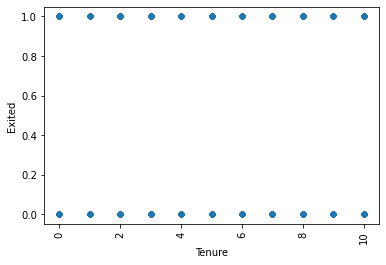

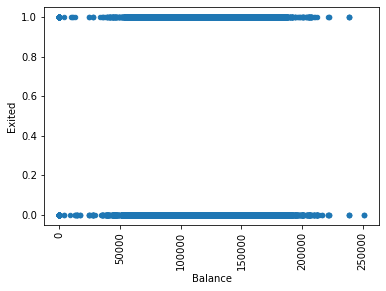

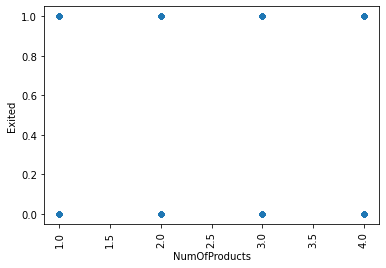

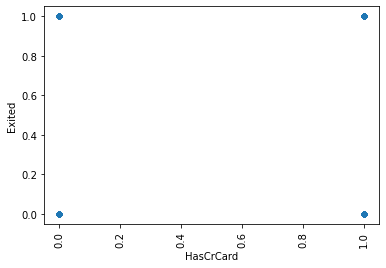

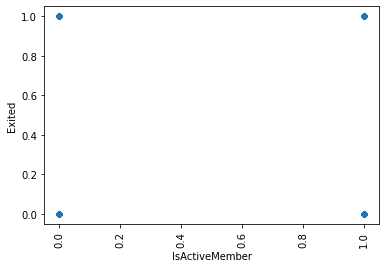

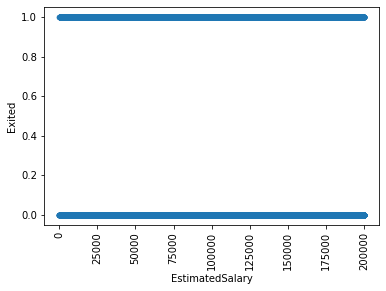

In [13]:
data_schema = data_validation.get_data_schema(raw_df)
target = 'Exited'
for key, value in data_schema.items():
    if key == target:
        continue
    if value == 'object':
        data_exploration.xy_boxplot(raw_df, key, target)
    else:
        data_exploration.xy_scatterplot(raw_df, key, target)

### Feature Engineering

In [5]:
pr_df = raw_df.copy()
pr_df.drop(['id', 'CustomerId'], axis=1, inplace=True)

- Customer names

In [6]:
import re

def clean_names(names):
    special_char = {
        'ß':'b', 
        'ã':'a', 
        'ä': 'a', 
        'è': 'e', 
        'é':'e', 
        'ë': 'e', 
        'ï':'i', 
        'ö':'o', 
        'ü':'u'
    }
    new_names = []
    max_length = 0
    for n in names:
        n = n.lower()
        for c,r in special_char.items():
            n = n.replace(c,r)
        a = re.sub('[^a-z]','',n)
        max_length = max(max_length, len(a))
        new_names.append(a)
    return new_names

def string_to_vector(array, max_length = 25):
    alphabet = {l:i+1 for i, l in enumerate(list('abcdefghijklmnopqrstuvwxyz'))}
    def converter(txt):
        if len(txt)>max_length:
            txt = txt[:max_length]
        vec = [0]*max_length
        for i, t in enumerate(list(txt.lower())):
            if t in alphabet:
                vec[i] = alphabet[t]
        
        return vec
    
    exp = []
    for txt in array:
        v = converter(txt)
        exp.append(v)

    return np.array(exp)

surnames = clean_names(pr_df['Surname'].values)
pr_df.drop('Surname', axis=1, inplace=True)
surname_vec = string_to_vector(surnames)


In [7]:
abrv_name = [name[:4] for name in surnames]
no_col = pr_df.shape[1]-1
pr_df.insert(no_col, 'abrv', abrv_name)

- Categorizing Credit Score

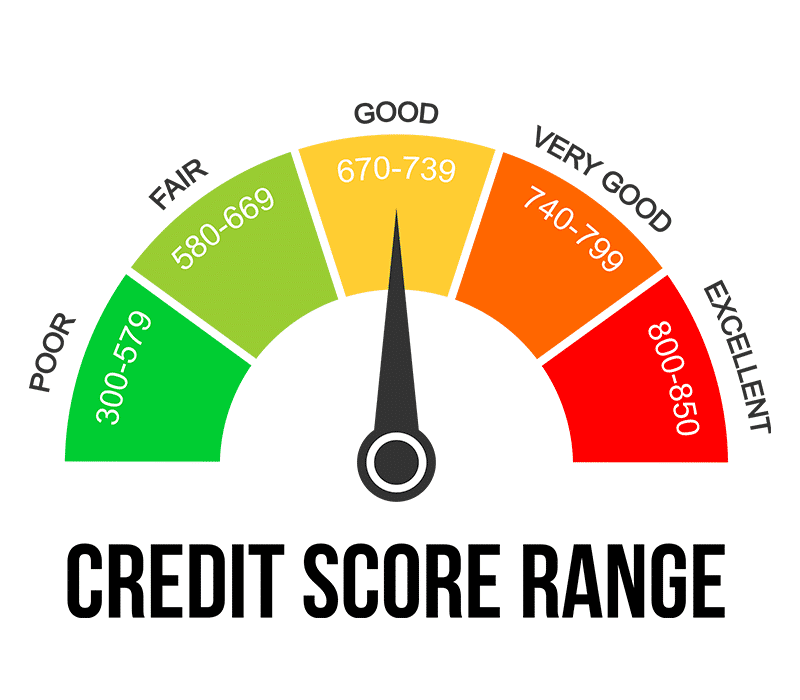

In [8]:
credit_range = {
    'Poor Credit': [300, 579],
    'Fair Credit': [580, 669],
    'Good Credit': [670, 739],
    'Very Good Credit': [740, 799],
    'Excellent Credit': [800, 850],
}
for key, val in credit_range.items():
    group = 1*((pr_df['CreditScore'].values>=val[0]) &
                 (pr_df['CreditScore'].values<=val[1]))
    no_col = pr_df.shape[1]-1
    pr_df.insert(no_col, key, group)

- Zero Balance

In [9]:
zeroBalance = 1*(pr_df['Balance']==0)

no_col = pr_df.shape[1]-1
pr_df.insert(no_col, 'zeroBalance', zeroBalance)

- Age buckets

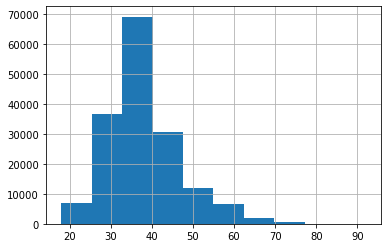

In [10]:
pr_df['Age'].hist()
age_range = {
    '20-25': [20, 25],
    '25-35': [25, 35],
    '35-65': [35, 65],
    '+65': [65, 100]
}
for key, val in age_range.items():
    group = 1*((pr_df['Age'].values>=val[0]) &
                 (pr_df['Age'].values<=val[1]))
    no_col = pr_df.shape[1]-1
    pr_df.insert(no_col, key, group)

- Salary Buckets

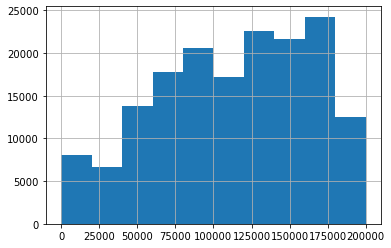

In [11]:
pr_df['EstimatedSalary'].hist()
salary_range = {
    '<20k': [0, 20000],
    '20k-50k': [20000, 50000],
    '50k-100k': [50000, 100000],
    '100k-150k': [100000, 150000],
    '150k+': [150000, 250000]

}
for key, val in salary_range.items():
    group = 1*((pr_df['EstimatedSalary'].values>=val[0]) &
                 (pr_df['EstimatedSalary'].values<=val[1]))
    no_col = pr_df.shape[1]-1
    pr_df.insert(no_col, key, group)

- encoder:
    - Geography
    - Gender
    - names

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

x = pr_df.iloc[:,:-1].values
y = pr_df.iloc[:,-1].values
columns = list(pr_df.columns)[:-1]

gender_en = LabelEncoder()
col_id = columns.index('Gender')
x[:,col_id] = gender_en.fit_transform(x[:,col_id])


encoded_features = ['Geography', 'abrv']

one_hat_columns = [columns.index(f) for f in encoded_features]
one_hat_encoder = ColumnTransformer(
        transformers= [
            ("one_hat_en", 
            OneHotEncoder(handle_unknown='ignore', sparse=False),
            one_hat_columns)
        ],
        remainder = 'passthrough'
        )
encoded_x = np.array(one_hat_encoder.fit_transform(x))

features =[]

for name in one_hat_encoder.get_feature_names_out():
    if 'x' not in name:
        continue
    f = name.split('x')[1]
    if '_' in f:
        n,v = f.split('_')
        n = int(n)
        f = "{}={}".format(columns[n],v)
    else:
        n = int(f)
        f = columns[n]
    features.append(f)
    print("{} -> {}".format(name, f))
ALL_FEATURES = features

#ALL_FEATURES += ['char {}'.format(i+1) for i in range(surname_vec.shape[1])] 
#encoded_x = np.column_stack((encoded_x,surname_vec))

one_hat_en__x1_France -> Geography=France
one_hat_en__x1_Germany -> Geography=Germany
one_hat_en__x1_Spain -> Geography=Spain
one_hat_en__x10_abaz -> abrv=abaz
one_hat_en__x10_abbi -> abrv=abbi
one_hat_en__x10_abbo -> abrv=abbo
one_hat_en__x10_abdu -> abrv=abdu
one_hat_en__x10_abel -> abrv=abel
one_hat_en__x10_aber -> abrv=aber
one_hat_en__x10_abra -> abrv=abra
one_hat_en__x10_abre -> abrv=abre
one_hat_en__x10_abro -> abrv=abro
one_hat_en__x10_ache -> abrv=ache
one_hat_en__x10_adam -> abrv=adam
one_hat_en__x10_afam -> abrv=afam
one_hat_en__x10_afan -> abrv=afan
one_hat_en__x10_agaf -> abrv=agaf
one_hat_en__x10_agui -> abrv=agui
one_hat_en__x10_aher -> abrv=aher
one_hat_en__x10_ahme -> abrv=ahme
one_hat_en__x10_ahmo -> abrv=ahmo
one_hat_en__x10_aike -> abrv=aike
one_hat_en__x10_ains -> abrv=ains
one_hat_en__x10_aitk -> abrv=aitk
one_hat_en__x10_ajul -> abrv=ajul
one_hat_en__x10_akab -> abrv=akab
one_hat_en__x10_aker -> abrv=aker
one_hat_en__x10_akht -> abrv=akht
one_hat_en__x10_akob -> 

In [13]:
sc = MinMaxScaler()
x_scaled = sc.fit_transform(encoded_x)
x_copy = x_scaled.copy()
feature_copy = ALL_FEATURES.copy()
cols = [
 ['*', 'HasCrCard', 'IsActiveMember'],
 ['/', 'EstimatedSalary','Tenure'],
 ['/', 'NumOfProducts','Tenure'],
 ['*', 'zeroBalance','20-25'],
 ['*', 'Geography=Germany','Gender'],
 ['*', '20-25','Gender'],
]
for s, f1, f2 in cols:
        i = ALL_FEATURES.index(f1)
        j = ALL_FEATURES.index(f2)
        if s=='*':
                a = x_copy[:, i] * x_copy[:, j]
        else:
                a = x_copy[:, i] / (0.0001+x_copy[:, j])
        feature_copy.append("{}{}{}".format(f1, s, f2))
        x_copy = np.column_stack((x_copy, a))
print(x_copy.shape)


(165034, 2017)


- Feature Correlations

Top 20 highly correlated features:
                            Row                    Column     value
9042  HasCrCard*IsActiveMember            IsActiveMember  0.771047
8774                     35-65                       Age  0.613636
8256                   Balance         Geography=Germany  0.539208
8514             NumOfProducts                   Balance  0.361033
9308                   Existed                       Age  0.340768
9173         zeroBalance*20-25                       Age  0.253057
9312                   Existed                     35-65  0.241094
9310                   Existed             NumOfProducts  0.214554
9180                   Existed         Geography=Germany  0.211054
9311                   Existed            IsActiveMember  0.210237
9177         zeroBalance*20-25                     35-65  0.194824
9314                   Existed  HasCrCard*IsActiveMember  0.178343
9307                   Existed                    Gender  0.146442
9174         zeroBalance*2

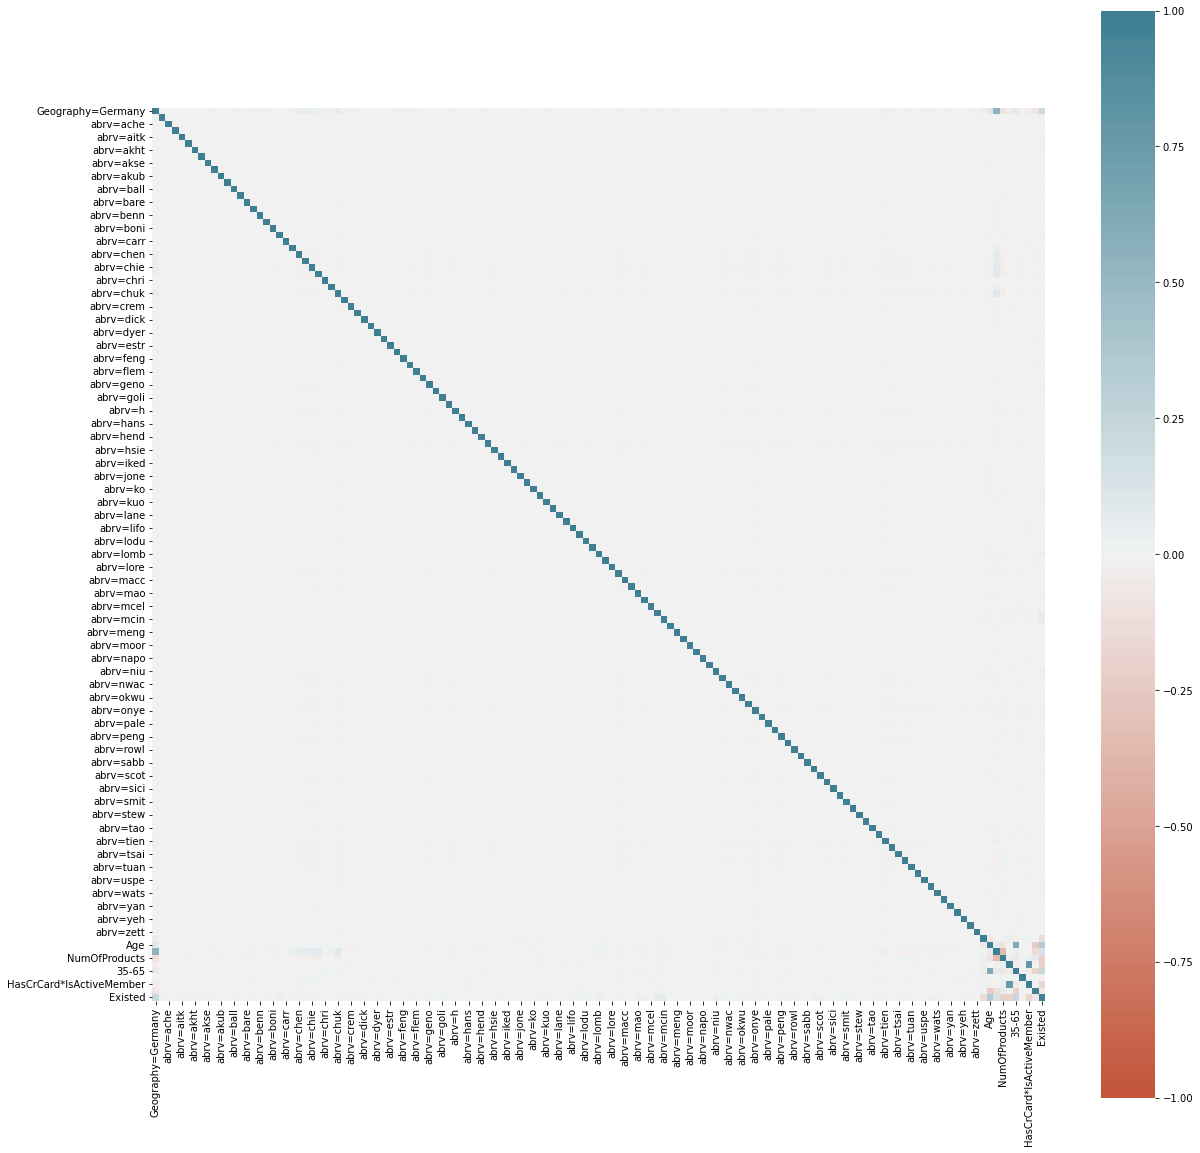

In [26]:
import seaborn as sns

copy_df = pd.DataFrame(x_copy.astype('float'),columns=feature_copy)
copy_df['Existed'] = y

corr = copy_df.corr().fillna(0)
fig,ax = plt.subplots(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

is_lower_triangle = 1- np.triu(np.ones(corr.shape)).astype('bool')
df = corr.where(is_lower_triangle==1)
df = df.stack().reset_index()
df.columns = ['Row','Column','value']

df['value'] = np.abs(df['value'].values)
df.sort_values(by='value', ascending=False, inplace=True)

print("Top 20 highly correlated features:\n",
    df.head(20))

print("\nTop 20 features correlated to Y :\n",
    df.query('`Row`=="Existed"').head(20))

- Drop Correlated features

In [27]:
y_col = 'Exited'
threshold = 0.75

correlated_feautres = set()
seen_features = set()
for i, row in df.iterrows():
    if row['Row']== y_col or row['Column'] == y_col:
        continue

    if row['value']<threshold or \
        row['Row']== row['Column']:
        continue
    if row['Row'] in seen_features or\
        row['Column'] in seen_features:
         continue
    seen_features.add(row['Row'])
    seen_features.add(row['Column'])
    if  row['Row'] not in correlated_feautres:
        correlated_feautres.add(row['Column'])

is_correlated = []

for i,f in enumerate(feature_copy):
    if f not in correlated_feautres:
        is_correlated.append(i)
feature_copy = list(np.array(feature_copy)[is_correlated])
x_copy = x_copy[:,is_correlated]

In [28]:
x_copy.shape

(165034, 135)

- Feature Importance

TOP 30 important features
                       feature     score
1992             NumOfProducts  0.193824
1994            IsActiveMember  0.047523
1989                       Age  0.045208
2004                     35-65  0.020285
1            Geography=Germany  0.016451
1988                    Gender  0.011249
1991                   Balance  0.009509
1171                 abrv=mcgr  0.007845
2011  HasCrCard*IsActiveMember  0.007588
1072                 abrv=lomb  0.007275
1296                  abrv=niu  0.007115
1129                  abrv=mao  0.007061
1455                 abrv=pisa  0.006856
1173                 abrv=mcin  0.006612
27                   abrv=akht  0.006487
1377                 abrv=onye  0.006428
979                    abrv=ku  0.006398
1405                 abrv=pale  0.006375
1583                 abrv=sage  0.006202
1613                 abrv=scot  0.005917
1136                 abrv=mart  0.005853
1868                 abrv=walk  0.005682
230                  abrv=brow 

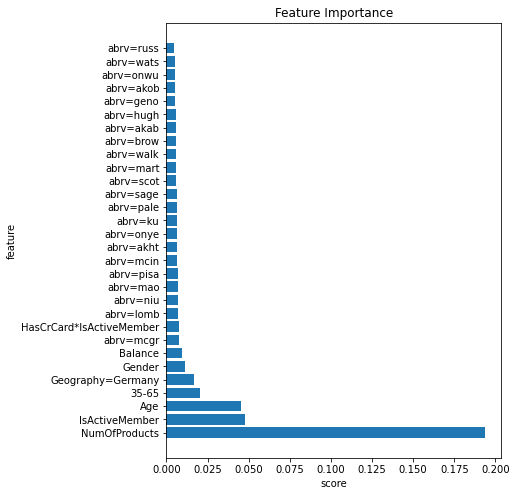

In [14]:
im_df = feature_importance(x_copy, y, feature_copy, is_classifer=True, top_k=30)

- Drop un-important features

In [24]:
unimportant_feautres= im_df.query('score < 0.002')['feature'].values

is_important = []

for i,f in enumerate(feature_copy):
    if f not in unimportant_feautres:
        is_important.append(i)
feature_copy = list(np.array(feature_copy)[is_important])
x_copy = x_copy[:,is_important]
x_copy.shape

(165034, 136)

## Model Development

In [29]:
x_train, x_test, y_train, y_test = train_test_split(
    x_copy, y, test_size=0.3, random_state=123
)
print(x_train.shape, y_train.shape)


(115523, 135) (115523,)


In [30]:
sample_x, sample_y = x_train[:1000], y_train[:1000]
base_model = compare_models(sample_x, sample_y)

lr	Accuracy: 0.84	AUC: 0.65	Recall: 0.84	Precision: 0.82	F1-Score: 0.81	Kappa: 0.37	MCC: 0.40	Log Loss: 0.39	Training Time: 0.02	
knn	Accuracy: 0.84	AUC: 0.69	Recall: 0.84	Precision: 0.83	F1-Score: 0.83	Kappa: 0.43	MCC: 0.44	Log Loss: 1.90	Training Time: 0.00	
nb	Accuracy: 0.30	AUC: 0.51	Recall: 0.30	Precision: 0.69	F1-Score: 0.27	Kappa: 0.01	MCC: 0.02	Log Loss: 24.28	Training Time: 0.00	
dt	Accuracy: 0.81	AUC: 0.71	Recall: 0.81	Precision: 0.81	F1-Score: 0.81	Kappa: 0.41	MCC: 0.41	Log Loss: 6.43	Training Time: 0.00	
svm	Accuracy: 0.80	AUC: 0.50	Recall: 0.80	Precision: 0.64	F1-Score: 0.71	Kappa: 0.00	MCC: 0.00	Log Loss: 0.40	Training Time: 0.06	
rbfsvm	Accuracy: 0.81	AUC: 0.58	Recall: 0.81	Precision: 0.78	F1-Score: 0.77	Kappa: 0.22	MCC: 0.26	Log Loss: 0.44	Training Time: 0.12	
mlp	Accuracy: 0.82	AUC: 0.67	Recall: 0.82	Precision: 0.81	F1-Score: 0.81	Kappa: 0.39	MCC: 0.40	Log Loss: 0.48	Training Time: 0.75	
rf	Accuracy: 0.83	AUC: 0.70	Recall: 0.83	Precision: 0.82	F1-Score: 0.83	Kappa: 0.4

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,Log Loss,Training Time
10,gbc,0.863000,0.745874,0.863000,0.855413,0.855810,0.534566,0.542877,0.339737,0.120269
14,lgbm,0.839000,0.713915,0.839000,0.829700,0.831643,0.458812,0.464958,0.440091,0.092862
9,ada,0.841000,0.711724,0.841000,0.830659,0.832238,0.458210,0.466214,0.657929,0.070662
13,xgboost,0.834000,0.714585,0.834000,0.826186,0.828210,0.452116,0.456306,0.489808,0.188771
12,et,0.834000,0.716334,0.834000,0.826255,0.828783,0.454690,0.457680,1.488355,0.120203
7,rf,0.835000,0.702048,0.835000,0.823975,0.826153,0.438168,0.445608,0.614189,0.116492
1,knn,0.839000,0.688538,0.839000,0.825634,0.825513,0.427851,0.443170,1.901972,0.001198
6,mlp,0.825000,0.672211,0.825000,0.810061,0.812681,0.388858,0.399627,0.479240,0.751426
0,lr,0.838000,0.649297,0.838000,0.820835,0.811460,0.365437,0.402159,0.391114,0.021231
3,dt,0.810000,0.706904,0.810000,0.811173,0.809870,0.410978,0.412544,6.433982,0.004205



*******
Results for model GradientBoostingClassifier(random_state=123):



,metrics,train,validation
0,Accuracy,0.87,0.86
1,AUC,0.74,0.74
2,Recall,0.87,0.86
3,Precision,0.86,0.86
4,F1-Score,0.86,0.86
5,Kappa,0.55,0.55
6,MCC,0.56,0.56
7,Log Loss,0.32,0.32
8,Training Time,198.41,198.41


              precision    recall  f1-score   support

           0       0.88      0.96      0.92     38922
           1       0.77      0.53      0.63     10589

    accuracy                           0.86     49511
   macro avg       0.83      0.74      0.77     49511
weighted avg       0.86      0.86      0.86     49511



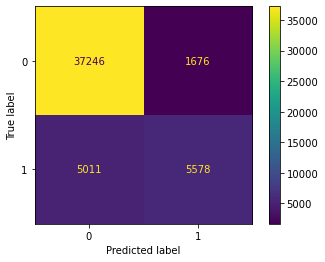

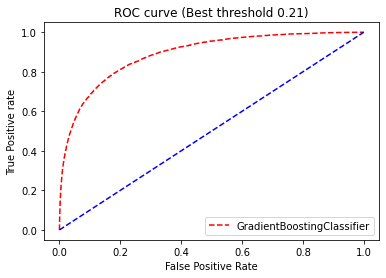

In [20]:
base_model,_ = train_a_model(x_train, y_train, x_test, y_test, base_model)

model_evaluation(base_model, x_test, y_test)

- Oversampling

In [31]:
from imblearn.over_sampling import SMOTE

sampler = SMOTE(random_state=123, sampling_strategy=1)

sample_x, sample_y = x_train[:1000], y_train[:1000]
sample_x, sample_y = sampler.fit_resample(sample_x, sample_y)
base_model_over = compare_models(sample_x, sample_y)

lr	Accuracy: 0.77	AUC: 0.77	Recall: 0.77	Precision: 0.77	F1-Score: 0.77	Kappa: 0.54	MCC: 0.54	Log Loss: 0.47	Training Time: 0.02	
knn	Accuracy: 0.83	AUC: 0.83	Recall: 0.83	Precision: 0.83	F1-Score: 0.83	Kappa: 0.66	MCC: 0.66	Log Loss: 1.30	Training Time: 0.00	
nb	Accuracy: 0.57	AUC: 0.57	Recall: 0.57	Precision: 0.71	F1-Score: 0.48	Kappa: 0.13	MCC: 0.23	Log Loss: 14.97	Training Time: 0.00	
dt	Accuracy: 0.84	AUC: 0.84	Recall: 0.84	Precision: 0.84	F1-Score: 0.84	Kappa: 0.68	MCC: 0.68	Log Loss: 5.31	Training Time: 0.01	
svm	Accuracy: 0.74	AUC: 0.74	Recall: 0.74	Precision: 0.74	F1-Score: 0.74	Kappa: 0.48	MCC: 0.48	Log Loss: 0.50	Training Time: 0.21	
rbfsvm	Accuracy: 0.86	AUC: 0.86	Recall: 0.86	Precision: 0.86	F1-Score: 0.86	Kappa: 0.72	MCC: 0.72	Log Loss: 0.38	Training Time: 0.33	
mlp	Accuracy: 0.84	AUC: 0.84	Recall: 0.84	Precision: 0.84	F1-Score: 0.84	Kappa: 0.68	MCC: 0.68	Log Loss: 0.39	Training Time: 1.25	
rf	Accuracy: 0.88	AUC: 0.88	Recall: 0.88	Precision: 0.89	F1-Score: 0.88	Kappa: 0.7

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,Log Loss,Training Time
12,et,0.890349,0.890334,0.890349,0.892116,0.890254,0.780694,0.782456,0.677174,0.151599
13,xgboost,0.885966,0.885951,0.885966,0.886712,0.885929,0.771929,0.772674,0.332299,0.194248
7,rf,0.884085,0.884072,0.884085,0.885237,0.884014,0.768167,0.769318,0.368329,0.146399
14,lgbm,0.879077,0.879076,0.879077,0.879440,0.879059,0.758157,0.758517,0.328506,0.087306
10,gbc,0.866550,0.866576,0.866550,0.868278,0.866405,0.733117,0.734833,0.314672,0.183741
5,rbfsvm,0.857768,0.857740,0.857768,0.858634,0.857680,0.715518,0.716390,0.377961,0.327033
9,ada,0.845245,0.845244,0.845245,0.846489,0.845130,0.690495,0.691734,0.663739,0.098303
6,mlp,0.838335,0.838302,0.838335,0.843738,0.837738,0.676651,0.682014,0.389989,1.252446
1,knn,0.830835,0.830798,0.830835,0.833656,0.830509,0.661645,0.664454,1.297036,0.001992
3,dt,0.840858,0.840845,0.840858,0.843522,0.840543,0.681706,0.684366,5.310425,0.005471


In [23]:
base_model_over = ExtraTreesClassifier(random_state=123)


*******
Results for model ExtraTreesClassifier(random_state=123):



,metrics,train,validation
0,Accuracy,1.00,0.85
1,AUC,1.00,0.75
2,Recall,1.00,0.85
3,Precision,1.00,0.84
4,F1-Score,1.00,0.85
5,Kappa,1.00,0.53
6,MCC,1.00,0.53
7,Log Loss,0.00,0.39
8,Training Time,198.64,198.64


              precision    recall  f1-score   support

           0       0.89      0.92      0.91     38922
           1       0.67      0.58      0.62     10589

    accuracy                           0.85     49511
   macro avg       0.78      0.75      0.76     49511
weighted avg       0.84      0.85      0.85     49511



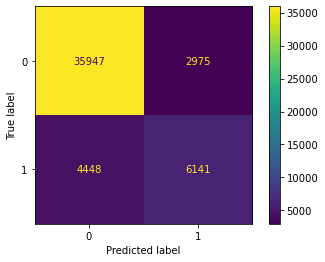

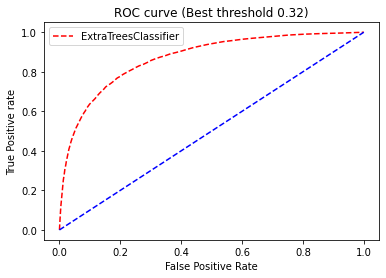

In [24]:
x_over, y_over = sampler.fit_resample(x_train, y_train)
base_model_over,_ = train_a_model(x_over, y_over, x_test, y_test, base_model_over)

model_evaluation(base_model_over, x_test, y_test)

In [32]:
tuned_rf, rf_param = tune_a_classifier('rf', sample_x, sample_y)
tuned_lgb, lgb_param = tune_a_classifier('lgbm', sample_x, sample_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'subsample': 0.9, 'reg_lambda': 0.1, 'reg_alpha': 0.1, 'num_leaves': 15, 'n_estimators': 300, 'min_split_gain': 0.1, 'min_child_samples': 20, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8, 'boosting_type': 'dart'}


In [34]:
lgb_param_2 = {
    "objective": "binary",
    "metric": "auc",
    "device": "gpu",
    "boosting": "goss",
    "learning_rate": 0.018,
    "feature_fraction": 0.5,
    "bagging_fraction": 0.5,
    "lambda_l1": 1.1214323077269823,
    "lambda_l2": 0.005114020277529055,
    "n_jobs": -1,
    "is_unbalance": True,
    "verbose": -1,
    "seed": 42,
}

tuned_lgb2 = LGBMClassifier(**lgb_param_2)



*******
Results for model LGBMClassifier(boosting_type='dart', colsample_bytree=0.8, learning_rate=0.2,
               max_depth=5, min_split_gain=0.1, n_estimators=300, num_leaves=15,
               random_state=123, reg_alpha=0.1, reg_lambda=0.1, subsample=0.9):



,metrics,train,validation
0,Accuracy,0.85,0.83
1,AUC,0.85,0.80
2,Recall,0.85,0.83
3,Precision,0.85,0.85
4,F1-Score,0.85,0.84
5,Kappa,0.69,0.54
6,MCC,0.69,0.55
7,Log Loss,0.36,0.39
8,Training Time,9.04,9.04


              precision    recall  f1-score   support

           0       0.92      0.86      0.89     38922
           1       0.58      0.74      0.65     10589

    accuracy                           0.83     49511
   macro avg       0.75      0.80      0.77     49511
weighted avg       0.85      0.83      0.84     49511



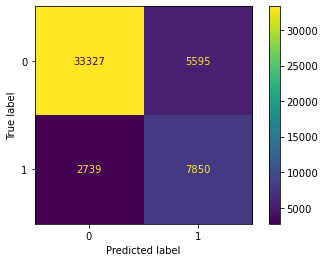

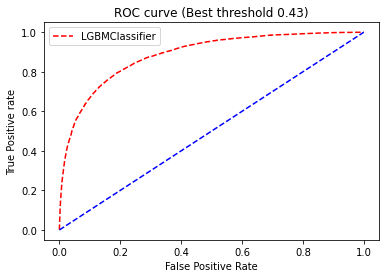

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.1214323077269823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1214323077269823
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005114020277529055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005114020277529055

*******
Results for model LGBMClassifier(bagging_fraction=0.5, boosting='goss', device='gpu',
               feature_fraction=0.5, is_unbalance=True,
               lambda_l1=1.1214323077269823, lambda_l2=0.005114020277529055,
               learning_rate=0.018, metric='auc', objective='binary', seed=42,
               verbose=-1):



,metrics,train,validation
0,Accuracy,0.82,0.82
1,AUC,0.82,0.80
2,Recall,0.82,0.82
3,Precision,0.82,0.85
4,F1-Score,0.82,0.83
5,Kappa,0.65,0.52
6,MCC,0.65,0.54
7,Log Loss,0.44,0.45
8,Training Time,4.46,4.46


              precision    recall  f1-score   support

           0       0.93      0.83      0.88     38922
           1       0.55      0.76      0.64     10589

    accuracy                           0.82     49511
   macro avg       0.74      0.80      0.76     49511
weighted avg       0.85      0.82      0.83     49511



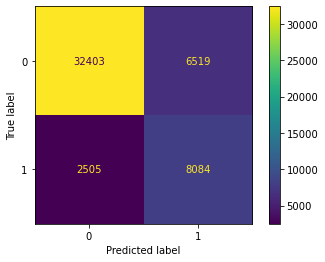

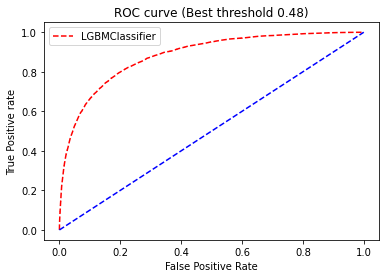

In [35]:
x_over, y_over = sampler.fit_resample(x_train, y_train)

tuned_lgb,_ = train_a_model(x_over, y_over, x_test, y_test, tuned_lgb)
model_evaluation(tuned_lgb, x_test, y_test)

tuned_lgb2,_ = train_a_model(x_over, y_over, x_test, y_test, tuned_lgb2)
model_evaluation(tuned_lgb2, x_test, y_test)

In [36]:
im_df = pd.DataFrame(
    {"feature": feature_copy, "score": tuned_lgb2.feature_importances_}
).sort_values(by="score", ascending=False)

display(im_df.head(50))

top_20_feature = im_df.head(50)["feature"].values
ids = np.where(np.in1d(feature_copy, top_20_feature))[0]
top_x_over = x_over[:, ids]
top_x_test = x_test[:, ids]
top_sample_x = sample_x[:, ids]

,feature,score
128,Age,1046
129,Balance,376
130,NumOfProducts,360
127,Gender,225
133,HasCrCard*IsActiveMember,165
0,Geography=Germany,140
131,35-65,54
77,abrv=mcgr,50
78,abrv=mcin,43
92,abrv=onye,42


[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.1214323077269823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1214323077269823
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005114020277529055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005114020277529055

*******
Results for model LGBMClassifier(bagging_fraction=0.5, boosting='goss', device='gpu',
               feature_fraction=0.5, is_unbalance=True,
               lambda_l1=1.1214323077269823, lambda_l2=0.005114020277529055,
               learning_rate=0.018, metric='auc', objective='binary', seed=42,
               verbose=-1):



,metrics,train,validation
0,Accuracy,0.82,0.81
1,AUC,0.82,0.80
2,Recall,0.82,0.81
3,Precision,0.82,0.85
4,F1-Score,0.82,0.82
5,Kappa,0.65,0.52
6,MCC,0.65,0.53
7,Log Loss,0.45,0.46
8,Training Time,2.85,2.85


              precision    recall  f1-score   support

           0       0.93      0.82      0.87     38922
           1       0.54      0.77      0.64     10589

    accuracy                           0.81     49511
   macro avg       0.74      0.80      0.76     49511
weighted avg       0.85      0.81      0.82     49511



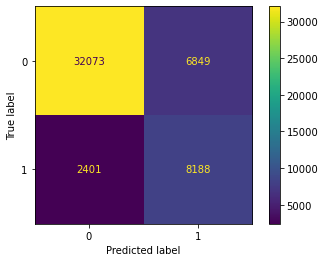

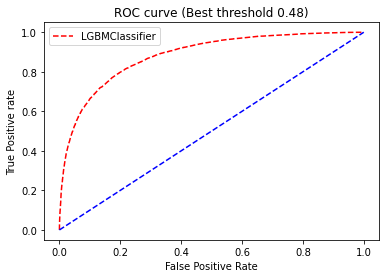

In [37]:
#best_param = rf_param.copy()
##best_param["n_estimators"] = 50
#best_param["max_depth"] = 15

#tune_model_over = RandomForestClassifier(**best_param)
tune_model_over,_ = train_a_model(top_x_over, y_over, top_x_test, y_test, tuned_lgb2)

model_evaluation(tune_model_over, top_x_test, y_test)

- Ensembling

In [38]:
y_pred = tune_model_over.predict(top_x_test)

wrong_predictions = np.where((y_pred!=y_test))
wrong_x, wrong_y = top_x_test[wrong_predictions], y_test[wrong_predictions]

random_state = 123
models = {
            "lr": LogisticRegression(random_state=random_state),
            "knn": KNeighborsClassifier(),
            "nb": GaussianNB(),
            "dt": DecisionTreeClassifier(random_state=random_state),
            "mlp": MLPClassifier(random_state=random_state),
            "qda": QuadraticDiscriminantAnalysis(),
            "ada": AdaBoostClassifier(random_state=random_state),
            "gbc": GradientBoostingClassifier(random_state=random_state),
            "lda": LinearDiscriminantAnalysis(),
            "et": ExtraTreesClassifier(random_state=random_state),
            "xgboost": XGBClassifier(
                random_state=random_state,
            ),
            "lgbm": LGBMClassifier(random_state=random_state),
        }
for key, model in models.items():
    model.fit(top_sample_x, sample_y)
    y_p = model.predict(wrong_x)
    accuracy = accuracy_score(wrong_y, y_p)
    auc = roc_auc_score(wrong_y, y_p, average="weighted")
    print("{}: Accuracy = {:.3f} AUC = {:.3f}".format(
        key, accuracy, auc))


lr: Accuracy = 0.185 AUC = 0.196
knn: Accuracy = 0.378 AUC = 0.316
nb: Accuracy = 0.300 AUC = 0.485
dt: Accuracy = 0.464 AUC = 0.363


C:\Users\mapmxj\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\mapmxj\AppData\Roaming\Python\Python39\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


mlp: Accuracy = 0.272 AUC = 0.237
qda: Accuracy = 0.282 AUC = 0.488
ada: Accuracy = 0.212 AUC = 0.173
gbc: Accuracy = 0.238 AUC = 0.180
lda: Accuracy = 0.180 AUC = 0.194
et: Accuracy = 0.474 AUC = 0.375
xgboost: Accuracy = 0.414 AUC = 0.306
lgbm: Accuracy = 0.394 AUC = 0.295


In [40]:
from sklearn.ensemble import VotingClassifier

random_state = 123

models = {
    "lr": LogisticRegression(random_state=random_state),
    "knn": KNeighborsClassifier(),
    "nb": GaussianNB(),
    "et": ExtraTreesClassifier(random_state=random_state, n_estimators=10,max_depth=1
    ),
    "mlp": MLPClassifier(random_state=random_state),
    "qda": QuadraticDiscriminantAnalysis(),
    "lda": LinearDiscriminantAnalysis(),
    "ada": AdaBoostClassifier(random_state=random_state),
    "gbc": GradientBoostingClassifier(random_state=random_state),
    "rf": RandomForestClassifier(random_state=random_state),
    'lgbml': LGBMClassifier(**lgb_param)
}

ensemble_models = {}
keys = list(models.keys())
for i in range(len(models) - 1):
    for j in range(i + 1, len(models)):
        model1, model2 = keys[i], keys[j]
        ensemble_models["{}_{}".format(model1, model2)] = VotingClassifier(
            estimators=[('tuned_rf', tune_model_over),
                        (model1, models[model1]), 
                        (model2, models[model2])],
            voting="soft",
            weights=[0.8, 0.1,0.1]
        )

ensemble = compare_models(
    top_sample_x, sample_y,
    ensemble_models)


[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.1214323077269823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1214323077269823
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005114020277529055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005114020277529055
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.1214323077269823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1214323077269823
[LightGBM] [War

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,Log Loss,Training Time
17,knn_rf,0.876581,0.876588,0.876581,0.877770,0.876509,0.753170,0.754353,0.391463,1.183357
52,gbc_rf,0.875319,0.875326,0.875319,0.876732,0.875212,0.750650,0.752054,0.392015,1.144528
54,rf_lgbml,0.874692,0.874701,0.874692,0.875705,0.874617,0.749393,0.750399,0.407163,2.912989
50,ada_rf,0.875319,0.875330,0.875319,0.876346,0.875242,0.750648,0.751667,0.424814,1.074015
38,mlp_rf,0.872815,0.872834,0.872815,0.874478,0.872688,0.745645,0.747295,0.395924,2.117158
32,et_rf,0.874692,0.874701,0.874692,0.875890,0.874608,0.749395,0.750585,0.424106,1.215036
16,knn_gbc,0.870940,0.870959,0.870940,0.872550,0.870809,0.741898,0.743494,0.394766,1.053659
14,knn_lda,0.869685,0.869705,0.869685,0.871306,0.869547,0.739385,0.740993,0.407705,1.175329
15,knn_ada,0.870942,0.870963,0.870942,0.872465,0.870814,0.741901,0.743410,0.427832,1.262256
47,lda_rf,0.869052,0.869088,0.869052,0.870535,0.868922,0.738126,0.739591,0.404612,1.035429


In [41]:
best_estimators = ensemble.get_params()['estimators']
ensemble_models = {
    "80_10_10": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.8, 0.1,0.1]
        ),
    "80_15_05": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.8, 0.15,0.05]
        ),
    "80_05_15": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.8, 0.05,0.15]
        ),
    "90_05_05": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.9, 0.05,0.05]
        ),
    "70_15_15": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.7, 0.15,0.15]
        ),
    "50_25_25": VotingClassifier(
            estimators=best_estimators,
            voting="soft",
            weights=[0.5, 0.25,0.25]
        ),
}
ensemble = compare_models(
    top_sample_x, sample_y,
    ensemble_models)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.1214323077269823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1214323077269823
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005114020277529055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005114020277529055
[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.1214323077269823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1214323077269823
[LightGBM] [War

,Model,Accuracy,AUC,Recall,Precision,F1-Score,Kappa,MCC,Log Loss,Training Time
2,80_05_15,0.879710,0.879721,0.879710,0.880982,0.879630,0.759430,0.760693,0.390008,1.077413
4,70_15_15,0.879079,0.879092,0.879079,0.880309,0.879004,0.758168,0.759390,0.375763,1.068116
5,50_25_25,0.876573,0.876576,0.876573,0.877837,0.876497,0.753151,0.754409,0.348494,1.122259
0,80_10_10,0.876581,0.876588,0.876581,0.877770,0.876509,0.753170,0.754353,0.391468,1.056785
1,80_15_05,0.872819,0.872838,0.872819,0.874339,0.872712,0.745653,0.747162,0.393200,1.051764
3,90_05_05,0.870308,0.870326,0.870308,0.872061,0.870161,0.740632,0.742370,0.408483,1.096391


In [42]:
ensemble_model, _ = train_a_model(
    top_x_over,
    y_over,
    top_x_test,
    y_test,
    ensemble,
)
model_evaluation(ensemble_model, top_x_test, y_test)

[LightGBM] [Warning] boosting is set=goss, boosting_type=gbdt will be ignored. Current value: boosting=goss
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] lambda_l1 is set=1.1214323077269823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1214323077269823
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] lambda_l2 is set=0.005114020277529055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005114020277529055


KeyboardInterrupt: 


*******
Results for model VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     class_weight='balanced',
                                                     criterion='entropy',
                                                     max_depth=15,
                                                     max_features='log2',
                                                     n_estimators=50)),
                             ('gbc',
                              GradientBoostingClassifier(random_state=123)),
                             ('mlp', MLPClassifier(random_state=123))],
                 voting='soft'):



,metrics,train,validation
0,Accuracy,0.90,0.85
1,AUC,0.90,0.78
2,Recall,0.90,0.85
3,Precision,0.90,0.85
4,F1-Score,0.90,0.85
5,Kappa,0.80,0.56
6,MCC,0.80,0.56
7,Log Loss,0.27,0.35
8,Training Time,283.83,283.83


              precision    recall  f1-score   support

           0       0.91      0.91      0.91     38922
           1       0.65      0.66      0.65     10589

    accuracy                           0.85     49511
   macro avg       0.78      0.78      0.78     49511
weighted avg       0.85      0.85      0.85     49511



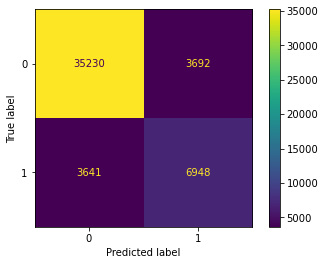

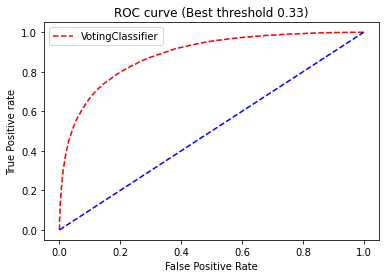

In [113]:
best_param["n_estimators"] = 50
best_param["max_depth"] = 15


ensemble = VotingClassifier(
            estimators=[('rf', RandomForestClassifier(**best_param)), 
                        ('gbc', models['gbc']),
                        ('mlp', models['mlp'])],
            voting="soft",
            weights=[0.8, 0.1, 0.1]
        )


ensemble_model2, _ = train_a_model(
    x_over,
    y_over,
    x_test,
    y_test,
    ensemble,
)
model_evaluation(ensemble_model2, x_test, y_test)

## NN model

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

class Wide(nn.Module):
    def __init__(self, n_feature):
        super().__init__()
        self.hidden = nn.Linear(n_feature, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x
    
class Deep(nn.Module):
    def __init__(self, n_feature):
        super().__init__()
        self.layer1 = nn.Linear(n_feature, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()
 
    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x


def over_sampling_train(x_tr, y_tr, batch_size=64):
    # Define a custom dataset class
    class CustomDataset(Dataset):
        def __init__(self, data, targets):
            self.data = data
            self.targets = targets

        def __len__(self):
            return len(self.data)

        def __getitem__(self, index):
            return self.data[index], self.targets[index]

    # Calculate class frequencies
    int_labels_tensor = torch.floor(y_tr).to(torch.int64).ravel()

    class_freq = torch.bincount(int_labels_tensor)
    class_weights = 1.0 / class_freq.float()

    # Assign weights to each sample based on its class
    weights = [class_weights[label] for label in int_labels_tensor]
    sampler = WeightedRandomSampler(weights, len(weights))

    # Create a DataLoader with the oversampled dataset
    dataset = CustomDataset(x_tr, y_tr)
    loader = DataLoader(dataset, sampler=sampler, batch_size=batch_size)
    return loader


def train_my_model(
    model, loader, n_epochs=100, verbose=True, x_val_tr=None, y_val_tr=None
):
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.BCELoss()
    sum_pr_time = 0
    n_batch = 0
    res = []
    for epoch in range(n_epochs):
        model.train()
        i = 0
        start_time = time.time()
        f1 = 0
        auc = 0
        tpr = 0
        for X_batch, y_batch in loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            y_pred = (y_pred > 0.5).int()
            f1 += f1_score(y_batch, y_pred, average="macro")
            auc += accuracy_score(y_batch, y_pred)
            i += 1
            if confusion_matrix(y_batch, y_pred).shape[0] == 2:
                _, _, fn, tp = confusion_matrix(y_batch, y_pred).ravel()
                tpr += tp / (tp + fn + 0.00009)
            loading = 0
            if n_batch != 0:
                loading = 100 * i / n_batch
            if verbose:
                print(
                    "Epoch {}: auc: {:.2f}\tf1: {:.2f}\tTPR: {:.3f}\tloss{:.2f}\
                    \t {:.2f}% ".format(
                        epoch, auc / i, f1 / i, tpr / i, loss.item(), loading
                    ),
                    end="\r",
                )
        if n_batch == 0:
            n_batch = i
        end_time = time.time()
        prt_time = end_time - start_time
        sum_pr_time += prt_time
        ave_time = sum_pr_time / (epoch + 1)
        t = int(ave_time * (n_epochs - epoch - 1))
        remaining_time = "{:02d}:{:02d}:{:02d}".format(
            t // 3600, (t // 60) % 60, t % 60
        )

        y_pred_val = 0
        loss_val = 0
        y_pred_val = 0
        f1_val = 0
        auc_val = 0
        tpr_val = 0
        if x_val_tr != None and y_val_tr != None:
            y_pred_val = model(x_val_tr)
            loss_val = loss_fn(y_pred_val, y_val_tr).item()
            y_pred_val = (y_pred_val > 0.5).int()
            f1_val = f1_score(y_val_tr, y_pred_val, average="macro")
            auc_val = accuracy_score(y_val_tr, y_pred_val)
            if confusion_matrix(y_val_tr, y_pred_val).shape[0] == 2:
                _, _, fn_val, tp_val = confusion_matrix(y_val_tr, y_pred_val).ravel()
                tpr_val = tp_val / (tp_val + fn_val + 0.00009)

        res.append(
            [
                epoch,
                auc / i,
                f1 / i,
                tpr / i,
                loss.item(),
                auc_val,
                f1_val,
                tpr_val,
                loss_val,
            ]
        )
        if verbose:
            verbos_format = (
                "Epoch {}: auc: {:.2f}\tf1: {:.2f}\tTPR: {:.3f}"
                + "\tloss{:.2f}\tend in {}\tval_auc: {:.2f}\tval_f1: {:.2f}"
                + "\tTPR: {:.3f}\tloss{:.2f}"
            )
            print(
                verbos_format.format(
                    epoch,
                    auc / i,
                    f1 / i,
                    tpr / i,
                    loss.item(),
                    remaining_time,
                    auc_val,
                    f1_val,
                    tpr_val,
                    loss_val,
                )
            )

    return pd.DataFrame(
        res,
        columns=[
            "epoch",
            "accuracy",
            "f1_score",
            "true_possitive_rate",
            "loss",
            "accuracy_val",
            "f1_score_val",
            "true_possitive_rate_val",
            "loss_val",
        ],
    )

def plot_learning_curve(df, train_col, val_col):
    fig, ax = plt.subplots()

    ax.plot(df[train_col].values, label="train")
    ax.plot(df[val_col].values, label="validation")
    plt.title("Model learning curve")
    plt.xlabel("epoch")
    plt.ylabel(train_col)
    plt.legend()
    plt.show()


In [87]:
x_train_tr = torch.tensor(x_train).float()
y_train_tr = torch.tensor(y_train.reshape(-1,1)).float()

x_test_tr = torch.tensor(x_test).float()
y_test_tr = torch.tensor(y_test.reshape(-1,1)).float()

print(x_train_tr.shape)
print(y_train_tr.shape)

torch.Size([115523, 53])
torch.Size([115523, 1])


In [99]:
batch_size = 64
n_epoch = 100
deep_model = Deep(x_train_tr.shape[1])

wide_model = Wide(x_train_tr.shape[1])
loader = over_sampling_train(x_train_tr, y_train_tr, batch_size)
res = train_my_model(wide_model, loader, n_epoch, 
               x_val_tr = x_test_tr, y_val_tr = y_test_tr)


Epoch 0: auc: 0.76	f1: 0.76	TPR: 0.759	loss0.29	end in 00:16:46	val_auc: 0.78	val_f1: 0.73	TPR: 0.816	loss0.47
Epoch 1: auc: 0.80	f1: 0.80	TPR: 0.794	loss0.39	end in 00:16:43	val_auc: 0.80	val_f1: 0.75	TPR: 0.796	loss0.43
Epoch 2: auc: 0.80	f1: 0.80	TPR: 0.791	loss0.40	end in 00:17:18	val_auc: 0.82	val_f1: 0.76	TPR: 0.754	loss0.40
Epoch 3: auc: 0.80	f1: 0.80	TPR: 0.797	loss0.11	end in 00:17:37	val_auc: 0.79	val_f1: 0.74	TPR: 0.812	loss0.45
Epoch 4: auc: 0.80	f1: 0.80	TPR: 0.796	loss0.49	end in 00:18:06	val_auc: 0.80	val_f1: 0.75	TPR: 0.793	loss0.44
Epoch 5: auc: 0.81	f1: 0.80	TPR: 0.797	loss0.19	end in 00:18:10	val_auc: 0.80	val_f1: 0.75	TPR: 0.800	loss0.44
Epoch 6: auc: 0.80	f1: 0.80	TPR: 0.795	loss0.36	end in 00:18:11	val_auc: 0.81	val_f1: 0.76	TPR: 0.777	loss0.41
Epoch 7: auc: 0.81	f1: 0.81	TPR: 0.800	loss0.95	end in 00:17:51	val_auc: 0.83	val_f1: 0.77	TPR: 0.739	loss0.39
Epoch 8: auc: 0.81	f1: 0.81	TPR: 0.800	loss0.44	end in 00:17:36	val_auc: 0.80	val_f1: 0.75	TPR: 0.797	loss0.44
E

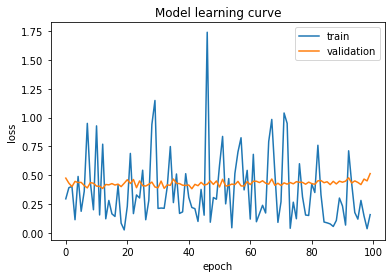

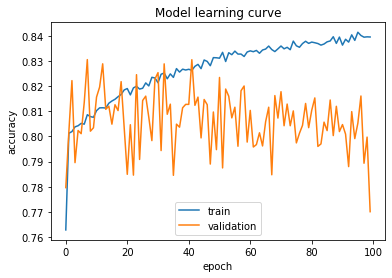

In [100]:
plot_learning_curve(res, 'loss', 'loss_val')
plot_learning_curve(res, 'accuracy', 'accuracy_val')

## Model Production

In [95]:
filename = "..\\data\\test.csv"
test_df = pd.read_csv(filename)

test_id = test_df['id'].values
test_df.drop(['id', 'CustomerId'], axis=1, inplace=True)

surnames = clean_names(test_df['Surname'].values)
test_df.drop('Surname', axis=1, inplace=True)
surname_vec = string_to_vector(surnames)

credit_range = {
    'Poor Credit': [300, 579],
    'Fair Credit': [580, 669],
    'Good Credit': [670, 739],
    'Very Good Credit': [740, 799],
    'Excellent Credit': [800, 850],
}
for key, val in credit_range.items():
    group = 1*((test_df['CreditScore'].values>=val[0]) &
                 (test_df['CreditScore'].values<=val[1]))
    no_col = test_df.shape[1]
    test_df.insert(no_col, key, group)

zeroBalance = 1*(test_df['Balance']==0)

no_col = test_df.shape[1]
test_df.insert(no_col, 'zeroBalance', zeroBalance)

age_range = {
    '20-25': [20, 25],
    '25-35': [25, 35],
    '35-65': [35, 65],
    '+65': [65, 100]
}
for key, val in age_range.items():
    group = 1*((test_df['Age'].values>=val[0]) &
                 (test_df['Age'].values<=val[1]))
    no_col = test_df.shape[1]
    test_df.insert(no_col, key, group)

salary_range = {
    '<20k': [0, 20000],
    '20k-50k': [20000, 50000],
    '50k-100k': [50000, 100000],
    '100k-150k': [100000, 150000],
    '150k+': [150000, 250000]

}
for key, val in salary_range.items():
    group = 1*((test_df['EstimatedSalary'].values>=val[0]) &
                 (test_df['EstimatedSalary'].values<=val[1]))
    no_col = test_df.shape[1]
    test_df.insert(no_col, key, group)

x_t = test_df.iloc[:,:].values

encoded_x_t = np.array(one_hat_encoder.transform(x_t))
encoded_x_t = np.column_stack((encoded_x_t,surname_vec))

x_scaled_t = sc.transform(encoded_x_t)

cols = ['Geography=France',
 'Geography=Germany',
 'Gender=Female',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Poor Credit',
 'Excellent Credit',
 'zeroBalance',
 '20-25',
 '+65',
 '150k+']
feature_copy_2 = ALL_FEATURES.copy()

for i, f in enumerate(cols):
    for f2 in cols:
        j = ALL_FEATURES.index(f2)
        if f == f2:
                continue
        a = x_scaled_t[:, i] * (1 - x_scaled_t[:, j]) 
        feature_copy_2.append("{}/{}".format(f, f2))
        x_scaled_t = np.column_stack((x_scaled_t, a))
        a = x_scaled_t[:, i] * x_scaled_t[:, j]
        feature_copy_2.append("{}*{}".format(f, f2))
        x_scaled_t = np.column_stack((x_scaled_t, a))

- random forest model

In [115]:
x_over, y_over = sampler.fit_resample(x_copy, y)

ensemble_model2.fit(x_over, y_over)
y_pred_t = ensemble_model2.predict_proba(x_scaled_t)[:,1]

pd.DataFrame({
    'id': test_id,
    'Exited':y_pred_t
}).to_csv('submission ensemble.csv', index=False)

C:\Users\mapmxj\AppData\Roaming\Python\Python39\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [102]:
x_over, y_over = sampler.fit_resample(x_copy, y)
ensemble_model.fit(x_over[:, ids], y_over)

ids_test = np.where(np.in1d(feature_copy_2, top_20_feature))[0]

top_x_r = pd.DataFrame(x_scaled_t[:, ids_test], columns = np.array(feature_copy_2)[ids_test]
                   )[top_20_feature].values

y_pred_t = ensemble_model.predict_proba(top_x_r)[:,1]

pd.DataFrame({
    'id': test_id,
    'Exited':y_pred_t
}).to_csv('submission ensemble 4.csv', index=False)

- Deep learning Model

In [104]:
x_t_tr = torch.tensor(x_scaled_t).float()
y_pred_t = wide_model(x_t_tr).detach().numpy().ravel()
pd.DataFrame({
    'id': test_id,
    'Exited':y_pred_t
}).to_csv('submission wide.csv', index=False)
